In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from itertools import product
import numpy as np
from shapely import ops
from shapely.geometry import *
from shapely import affinity
from shapely.ops import linemerge, unary_union, polygonize
import matplotlib.path as mpltPath
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
im = Image.open("download.jpeg")

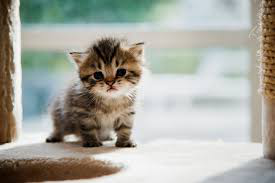

In [5]:
im

In [368]:
def get_image_polygon(im):
    h = im.size[0]
    w = im.size[1]
    imp = Polygon([(0,0),(h,0),(h,w),(0,w)])
    return imp


def generate_splitting_lines(center,half_length,start_angle,split_angle):
    cx = center.coords[0][0]
    cy = center.coords[0][1]
    l = LineString([(cx-half_length,cy),(cx+half_length,cy)])
    l = affinity.rotate(l,start_angle)
    ml = MultiLineString([l,affinity.rotate(l,split_angle)])
    middle_line = affinity.rotate(l,split_angle/2)
    return ml,middle_line

def split_polygon(ml,poly,select_line):
    merged = linemerge([poly.boundary, *ml])
    borders = unary_union(merged)
    polygons = list(polygonize(borders))
    mline_scaled_bounds = affinity.scale(select_line,.01,.01).boundary
    for i,j in product(polygons,polygons):
        if i == j:
            continue
        elif ops.unary_union([i,j]).contains(mline_scaled_bounds):
            return [i,j]
    return polygons

def get_cut(im_rect,start_angle=-30,split_angle=70):
    splitting_lines,middle_line = generate_splitting_lines(im_rect.centroid,im.size[0]+im.size[1],start_angle,split_angle)
    return split_polygon(splitting_lines,im_rect,middle_line)


def split_shape(shape,start_angle=-30,split_angle=70,num_rotations=1):
    polys=[]
    for r in range(1,num_rotations+1):
        polys.extend(get_cut(shape,start_angle=start_angle,split_angle=split_angle))
        start_angle = split_angle+start_angle
    return polys

def make_point_grid(width,height):
    '''
    h,w to be consisted with rows, columns
    '''
    return product(range(width),range(height))

def get_polygon_contain_indices(w,h,polygons):
    '''
    w,h to be consisted with rows, columns
    '''
    points = make_point_grid(w,h)
    im_poly = np.ones((w,h)) - 2
    for w,h in points:
        for idx,poly in enumerate(polygons):
            if poly.intersects(Point((w,h))):
                im_poly[w,h] = idx
    return im_poly

#pre-speed up
im = Image.open("download.jpeg")
imp = get_image_polygon(im)
polygons=split_shape(imp,start_angle=-30,split_angle=60,num_rotations=3)
get_polygon_contain_indices(w,h,polygons)



array([[2., 2., 2., ..., 5., 5., 5.],
       [2., 2., 2., ..., 5., 5., 5.],
       [2., 2., 2., ..., 5., 5., 5.],
       ...,
       [4., 4., 4., ..., 3., 3., 3.],
       [4., 4., 4., ..., 3., 3., 3.],
       [4., 4., 4., ..., 3., 3., 3.]])

In [14]:
%%writefile shape_splitter.py
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from shapely.geometry import Polygon
from PIL import Image
from itertools import product
import numpy as np
from shapely import ops
from shapely.geometry import *
from shapely import affinity
from shapely.ops import linemerge, unary_union, polygonize
import matplotlib.pyplot as plt


def get_w_h_polygon(w,h):
    imp = Polygon([(0,0),(h,0),(h,w),(0,w)])
    return imp


def get_image_polygon(im):
    h = im.size[0]
    w = im.size[1]
    imp = Polygon([(0,0),(h,0),(h,w),(0,w)])
    return imp


def generate_splitting_lines(center,half_length,start_angle,split_angle):
    cx = center.coords[0][0]
    cy = center.coords[0][1]
    l = LineString([(cx-half_length,cy),(cx+half_length,cy)])
    l = affinity.rotate(l,start_angle)
    ml = MultiLineString([l,affinity.rotate(l,split_angle)])
    middle_line = affinity.rotate(l,split_angle/2)
    return ml,middle_line

def split_polygon(ml,poly,select_line):
    merged = linemerge([poly.boundary, *ml])
    borders = unary_union(merged)
    polygons = list(polygonize(borders))
    mline_scaled_bounds = affinity.scale(select_line,.01,.01).boundary
    for i,j in product(polygons,polygons):
        if i == j:
            continue
        elif ops.unary_union([i,j]).contains(mline_scaled_bounds):
            return [i,j]
    return polygons

def get_cut(im_rect,start_angle=-30,split_angle=70):
    splitting_lines,middle_line = generate_splitting_lines(im_rect.centroid,sum(im_rect.boundary.coords[2]),start_angle,split_angle)
    return split_polygon(splitting_lines,im_rect,middle_line)


def split_shape(shape,start_angle=-30,split_angle=70,num_rotations=1):
    polys=[]
    for r in range(1,num_rotations+1):
        polys.extend(get_cut(shape,start_angle=start_angle,split_angle=split_angle))
        start_angle = split_angle+start_angle
    return polys

def make_point_grid(width,height):
    '''
    h,w to be consisted with rows, columns
    '''
    return product(range(width),range(height))


#Speed up func
def generate_codes(n):
    """ The first command needs to be a "MOVETO" command,
        all following commands are "LINETO" commands.
    """
    return [Path.MOVETO] + [Path.LINETO] * (n - 1)

def pathify(polygon):
    ''' Convert coordinates to path vertices. Objects produced by Shapely's
        analytic methods have the proper coordinate order, no need to sort.

        The codes will be all "LINETO" commands, except for "MOVETO"s at the
        beginning of each subpath
    '''
    vertices = list(polygon.exterior.coords)
    codes = generate_codes(len(polygon.exterior.coords))

    for interior in polygon.interiors:
        vertices.extend(interior.coords)
        codes.extend(self.generate_codes(len(interior.coords)))

    return Path(vertices, codes)

def get_polygon_contain_indices(w,h,polygons):
    '''
    returns list of (w,h) indices
    '''
    points = list(make_point_grid(w,h))
    paths = [pathify(poly) for poly in polygons]
    return [path.contains_points(points) for path in paths]

def split_image_by_angle(image_filename,start_angle,split_angle,num_rotations,return_polygons=True):
    '''
    Takes as input an image and the start angle and split angle, and splits it returning 
    
    '''
    im = Image.open(image_filename)
    w = im.size[0]
    h = im.size[1]
    im_polygon = get_image_polygon(im)
    polygons=split_shape(im_polygon,start_angle=start_angle,split_angle=split_angle,num_rotations=num_rotations)
    poly_masks = get_polygon_contain_indices(w,h,polygons)
    if return_polygons:
        return poly_masks,polygons
    else:
        return poly_masks
    
def plot_mask(mask):
    fig, ax = plt.subplots()
    ax.imshow(mask, cmap='binary');

    
# def get_camera_mask(camera_name):
#     camera_centroid = camera_to_centroid[camera]
#     return 

def get_mask_name(camera,shape):
    return camera.replace(".jpeg",f"_{shape[0]}.npy")
    

def get_split_info(image_filename_or_w_h_tuple,start_angle=-30,split_angle=60,num_rotations=1):
    if isinstance(image_filename_or_w_h_tuple,str):
        im = Image.open(image_filename_or_w_h_tuple)
        w = im.size[0]
        h = im.size[1]
        im_polygon = get_image_polygon(im)
    else:
        w,h = image_filename_or_w_h_tuple
        im_polygon = get_w_h_polygon(w,h)
    polygons=split_shape(im_polygon,start_angle=start_angle,split_angle=split_angle,num_rotations=num_rotations)
    poly_masks = get_polygon_contain_indices(w,h,polygons)
    for i in range(len(polygons)):
        plot_mask(poly_masks[i].reshape(w,h).transpose())
        plt.plot(*polygons[i].exterior.xy)
        plt.plot(polygons[i].centroid.coords[0][0],polygons[i].centroid.coords[0][1], 'x', color="red")
    polymasks = [m.reshape(w,h).transpose() for m in poly_masks]
    return polygons,poly_masks, [polygon.centroid.coords[0] for polygon in polygons]


def save_masks(downsample_shape,start_angle=-35,split_angle=70,num_rotations=3):
    p,masks,c = get_split_info(downsample_shape,start_angle,split_angle,num_rotations)
    c = [(int(i[0]),int(i[1])) for i in c]

    camera_centroid= {
        'CAM_BACK.jpeg': masks[0],
        'CAM_FRONT.jpeg': masks[1],
        'CAM_BACK_LEFT.jpeg':masks[2],
        'CAM_FRONT_RIGHT.jpeg':masks[3],
        'CAM_FRONT_LEFT.jpeg':masks[4],
        'CAM_BACK_RIGHT.jpeg':masks[5]
    }

    for k,v in camera_centroid.items():
        with open(get_mask_name(k,downsample_shape),"wb") as f:
            np.save(f,v)

Overwriting shape_splitter.py


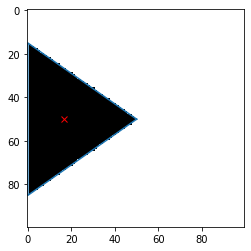

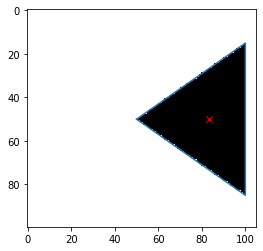

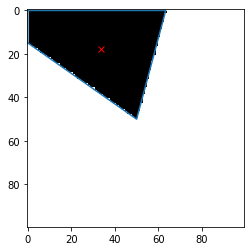

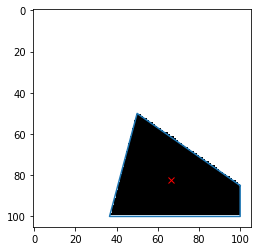

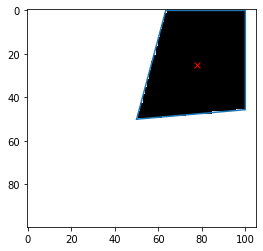

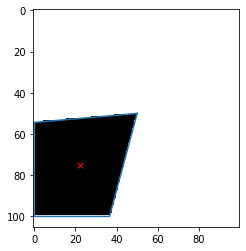

In [9]:
save_masks((100,100))

#polygons,polymasks,c = 
# fig, ax = plt.subplots()

# idx = 1
# ax.imshow(arr[idx].reshape(w,h), cmap='binary');

# ps[idx].centroid.coords[0]

# get_image_polygon(Image.open("download.jpeg"))
# plt.plot(*ps[0].exterior.xy)

